In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import Steerable.nn as snn

# Figure 2

### Spherical grid misalignment under right angle rotation

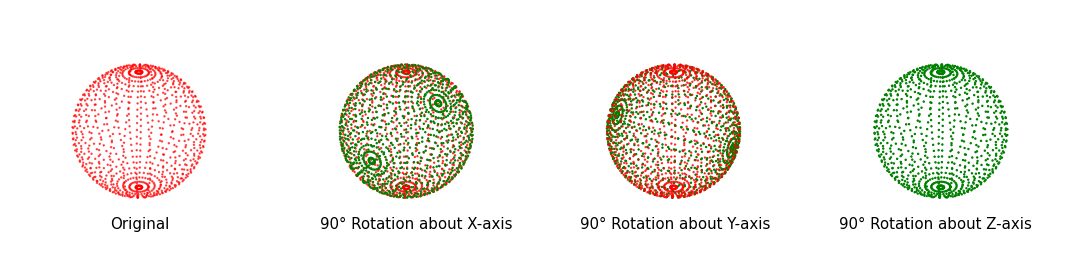

In [2]:
def spherical_grid_3d(n_angle):
    j = torch.arange(n_angle)
    theta, phi = torch.meshgrid(torch.pi * (j + 0.5) / n_angle, 2*torch.pi*(j+0.5) / n_angle, indexing='ij')
    x = (torch.sin(theta) * torch.cos(phi)).flatten()
    y = (torch.sin(theta) * torch.sin(phi)).flatten()
    z = torch.cos(theta).flatten()
    return torch.vstack([x, y, z])

def rotate_points(points, axis='x', angle_deg=90):
    angle_rad = np.radians(angle_deg)
    if axis == 'x':
        R = torch.tensor([[1, 0, 0],
                      [0, np.cos(angle_rad), -np.sin(angle_rad)],
                      [0, np.sin(angle_rad),  np.cos(angle_rad)]])
    elif axis == 'y':
        R = torch.tensor([[ np.cos(angle_rad), 0, np.sin(angle_rad)],
                      [0, 1, 0],
                      [-np.sin(angle_rad), 0, np.cos(angle_rad)]])
    elif axis == 'z':
        R = torch.tensor([[np.cos(angle_rad), -np.sin(angle_rad), 0],
                      [np.sin(angle_rad),  np.cos(angle_rad), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    return R.type(torch.float) @ points

def plot_rotated_vs_original(n_angle):
    points = spherical_grid_3d(n_angle)
    fig, axes = plt.subplots(nrows=1, ncols=4, subplot_kw={"projection": "3d"}, gridspec_kw={'hspace':0})
    fig.set_size_inches(15,4)
    
    for ax in axes:
        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        ax.set_box_aspect([1, 1, 1])
        ax.axis('off')

    # Plot original grid
    axes[0].scatter(points[0], points[1], points[2],
                color='red', s=2, alpha=0.6, label='Original')
    fig.text(0.105,0.175,s=f'Original', fontsize=15)

    for i, rotation_axis in enumerate(['x', 'y', 'z']):
        rotated = rotate_points(points, axis=rotation_axis, angle_deg=90)
        if rotation_axis in ['x', 'y']:
            # Plot original grid
            axes[i+1].scatter(points[0], points[1], points[2],
                    color='red', s=2, alpha=0.7, label='Original')

        # Plot rotated grid
        axes[i+1].scatter(rotated[0], rotated[1], rotated[2],
                   color='green', s=2, alpha=1.0, label=f'Rotated about {rotation_axis.upper()}')

        fig.text(0.24*i + 0.3,0.175,s=f'90° Rotation about {rotation_axis.upper()}-axis', fontsize=15)
        
    plt.tight_layout()
    plt.show()

# Main
plot_rotated_vs_original(32)

# Figure 3

### Error plot for rotations

In [2]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self, size, mean=0.0, std=1.0, length=1000):
        self.mean = mean
        self.std = std
        self.size = size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx >= self.length:
            raise ValueError(f'Index{idx} out of range for dataset of length {self.length}')
        image = torch.randn(self.size) * self.std + self.mean
        label = 0
        return image, label
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
degrees = torch.arange(0, 361, 10)
n_sim = 50

def check_equivariance(models, dataset, transfomation=None):
    values = torch.zeros(n_sim, len(models), len(degrees))
    for sim in range(n_sim):
        inputs = dataset[torch.randint(0, len(dataset), (1,)).item()][0]
        norm = torch.abs(inputs).mean()
        for i, model in enumerate(models):
            with torch.no_grad():
                for parameters in model.parameters():
                    parameters.copy_(torch.randn_like(parameters))
                for j, degree in enumerate(degrees):
                    with torch.no_grad():
                        outputs1 = model(inputs.unsqueeze(0).to(device))[0].cpu()
                        outputs2 = model(transfomation(inputs, degree).unsqueeze(0).to(device))[0].cpu()
                        values[sim, i, j] = 100 * (outputs1-outputs2).max().abs() / norm

        print(f'Simulation : {sim+1} / {n_sim}', end='\r')
    return torch.stack([values.mean(dim=0), values.std(dim=0)], dim=-1)
    

## 2D

In [ ]:
# Model
class Model(torch.nn.Module):
    def __init__(self, interpolation_type):
        super().__init__()
        freq_cutoff = 4
        n_angle = 256

        self.network = torch.nn.Sequential(
            snn.SE2ConvType1(1, 4, 5, freq_cutoff, n_angle=n_angle, interpolation_type=interpolation_type),
            snn.SE2ConvType2(4, 16, 5, freq_cutoff, n_angle=n_angle, interpolation_type=interpolation_type),
            snn.SE2NormFlatten()
        )
        
    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
dataset = GaussianDataset(size =(1,28,28))
stats_2d = check_equivariance([
    Model(interpolation_type=0).to(device),
    Model(interpolation_type=1).to(device),
    Model(interpolation_type=-1).to(device)
    ], 
    dataset, lambda x, degree:snn.rotate_image(x, degree, order=1))

/mnt/d/UCHICAGO/Academic/Projects/Steerable/Steerable/nn/Steerable2d/conv_layers.py:37: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = torch.conv2d(x, self.kernel, stride=self.stride, padding = self.padding, dilation=self.dilation)


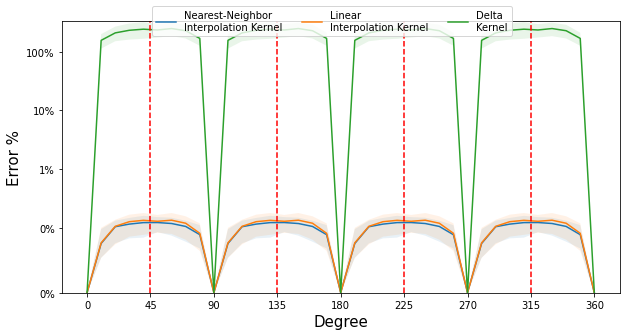

In [10]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,5)

labels = ['Nearest-Neighbor\nInterpolation Kernel',
          'Linear\nInterpolation Kernel',
          'Delta\nKernel']

for i in [0,1, -1]:
    axes.plot(degrees, stats_2d[i,:,0], label=labels[i])
    axes.fill_between(
        degrees,
        stats_2d[i,:,0] - 1.96*stats_2d[i,:,1]/sqrt(n_sim),
        stats_2d[i,:,0] + 1.96*stats_2d[i,:,1]/sqrt(n_sim),
        alpha=0.1
    )

axes.set_xticks([45*i for i in range(degrees.max().item()//45 + 1)])
for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
    axes.axvline(intercept, linestyle='dashed', color='red')

axes.set_ylabel('Error %', size=15)
axes.set_xlabel('Degree', size=15)

# >>> key line to “show the excessive gap”
axes.set_yscale('symlog', linthresh=0.1, linscale=1.0)    # tune linthresh as needed
axes.yaxis.set_major_formatter(PercentFormatter(100))     # optional, if your data are percents
axes.set_ylim(0)
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=3)

plt.show()


## 3D

In [12]:
# Model
class Model(torch.nn.Module):
    def __init__(self, interpolation_type) -> None:
        super().__init__()
        n_angle = 256
        self.network = torch.nn.Sequential(
            snn.SE3Conv(1, [4,4], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3Conv([4,4], [16,16], 5, n_angle=n_angle, padding='same', interpolation_type=interpolation_type),
            snn.SE3NormFlatten()
        )

    def forward(self,x):
        return self.network(x.type(torch.cfloat))
    
dataset = GaussianDataset(size =(1,32,32,32))
interpolation_type = 0
stats_3d_z = check_equivariance([
    Model(interpolation_type=0).to(device),
    Model(interpolation_type=1).to(device),
    Model(interpolation_type=-1).to(device)
    ], 
    dataset, lambda x, degree:snn.rotate_image(x, (degree, 0, 0), order=1))

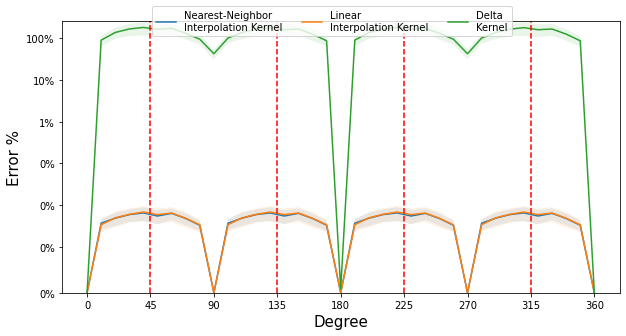

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,5)

labels = ['Nearest-Neighbor\nInterpolation Kernel',
          'Linear\nInterpolation Kernel',
          'Delta\nKernel']

for i in [0,1, -1]:
    axes.plot(degrees, stats_3d_z[i,:,0], label=labels[i])
    axes.fill_between(
        degrees,
        stats_3d_z[i,:,0] - 1.96*stats_3d_z[i,:,1]/sqrt(n_sim),
        stats_3d_z[i,:,0] + 1.96*stats_3d_z[i,:,1]/sqrt(n_sim),
        alpha=0.1
    )

axes.set_xticks([45*i for i in range(degrees.max().item()//45 + 1)])
for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
    axes.axvline(intercept, linestyle='dashed', color='red')

axes.set_ylabel('Error %', size=15)
axes.set_xlabel('Degree', size=15)

# >>> key line to “show the excessive gap”
axes.set_yscale('symlog', linthresh=0.001, linscale=1.0)    # tune linthresh as needed
axes.yaxis.set_major_formatter(PercentFormatter(100))     # optional, if your data are percents
axes.set_ylim(0)
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=3)

plt.show()


In [17]:
stats_3d_y = check_equivariance([
    Model(interpolation_type=0).to(device),
    Model(interpolation_type=1).to(device),
    Model(interpolation_type=-1).to(device)
    ], 
    dataset, lambda x, degree:snn.rotate_image(x, (0, degree, 0), order=1))

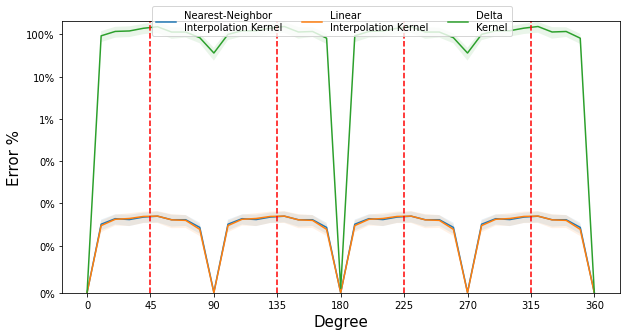

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10,5)

labels = ['Nearest-Neighbor\nInterpolation Kernel',
          'Linear\nInterpolation Kernel',
          'Delta\nKernel']

for i in [0,1, -1]:
    axes.plot(degrees, stats_3d_y[i,:,0], label=labels[i])
    axes.fill_between(
        degrees,
        stats_3d_y[i,:,0] - 1.96*stats_3d_y[i,:,1]/sqrt(n_sim),
        stats_3d_y[i,:,0] + 1.96*stats_3d_y[i,:,1]/sqrt(n_sim),
        alpha=0.1
    )

axes.set_xticks([45*i for i in range(degrees.max().item()//45 + 1)])
for intercept in [90*i+45 for i in range(round(degrees.max().item()/90))]:
    axes.axvline(intercept, linestyle='dashed', color='red')

axes.set_ylabel('Error %', size=15)
axes.set_xlabel('Degree', size=15)

# >>> key line to “show the excessive gap”
axes.set_yscale('symlog', linthresh=0.001, linscale=1.0)    # tune linthresh as needed
axes.yaxis.set_major_formatter(PercentFormatter(100))     # optional, if your data are percents
axes.set_ylim(0)
handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=3)

plt.show()
